# Visualize the Graph Network for Sports Apparel

We have been handed a dataset with ~175,000 tweets, collected over 93 days, that have a mention for Nike, Addidas, and Lululemon (@Nike, @Adidas, & @Lululemon). We are going to find out who the influencers are (weighted directed graph) and what are the biggest bridging accounts. If the influencers are the same for each brand, or differ. What words each company owns, and some other interesting tidbits from a brand marketing perspective. You'll notice that I choose to go through the original data each iteration instead of loading the information into memory. I found that saving the data to variables extended resource consumption beyond the limits of this free colab environment. Although the computations are a bit slower, the method enables a much more extended exploration of the data.

## Work To Do:

1. Import Data and Characterize
2. Filter Data to Influencers
3. Weighted Directed Graph of Influencers for all Brands
4. Filter Influencers by Brand
5. Directed Influencer Graphs by Brand
6. Semantic Segmentation of Influencers by Brand
7. Semantic Analysis
8. Directed Graphs of Brand Semantics
9. Brand Tweet Sentiment Scoring
10. Sentiment Analysis
11. Conclusion

To get started, we'll import some libraries:

In [38]:
import gzip
import json
import nltk
import networkx as nx, pandas as pd
import matplotlib.pyplot as plt
import statistics, re
from IPython.core.display import display, HTML
!pip install pyvis==0.3.1
from pyvis.network import Network
import nltk
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

DATA_FILE = "/content/Marketing-Network-Analysis-Data.jsonl.gz"

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import string
punctuation = string.punctuation
stopwordsset = set(stopwords.words("english"))
stopwordsset.add('rt')
stopwordsset.add("'s")

from textblob import TextBlob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
punctuation = punctuation +"..."+"[]"
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~...[]'

# Import and Characterize the Data

How many users? How popular are those users? How many times does each user tweet? Let's find out.

In [3]:
users = {}

with gzip.open(DATA_FILE) as data_file:
    for i, line in enumerate(data_file):
        if i % 10000 == 0: # Show a periodic status
            print("%s tweets processed" % i)
        tweet = json.loads(line)
        user = tweet["user"]
        user_id = user["id"]
        if user_id not in users:
            users[user_id] = {
                "id": user_id,
                "tweet_count": 0,
                "followers_count": user["followers_count"]
            }
        users[user_id]["tweet_count"] += 1
    print(f"{i} total Tweets processed")

print("Completed Processing. \n Number of Unique Twitter Users in Dictionary:", len(users))

0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
175077 total Tweets processed
Completed Processing. 
 Number of Unique Twitter Users in Dictionary: 104772


Great. We know there are 104,772 users who generated 175,077 tweets.

Mean Tweet Count: 1.67103806360478
Median Tweet Count: 1.0
Max Tweet Count by a Uswer: 7118


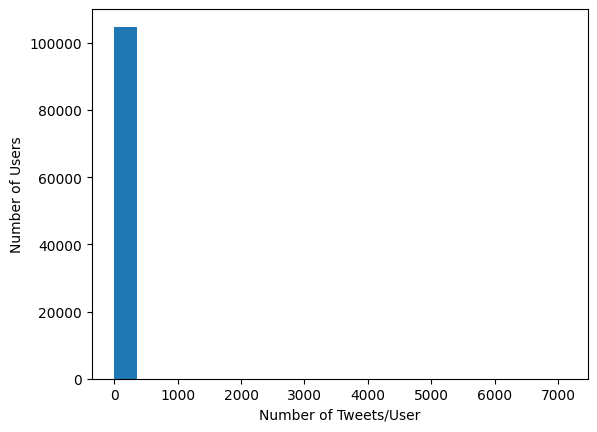

In [4]:
tweeted = [users[x]['tweet_count'] for x in users.keys()]
print("Mean Tweet Count:",statistics.mean(tweeted))
print("Median Tweet Count:",statistics.median(tweeted))
print("Max Tweet Count by a Uswer:",max(tweeted))
plt.ticklabel_format(style='plain')
plt.hist(tweeted,bins=20)
plt.xlabel("Number of Tweets/User")
plt.ylabel("Number of Users")
plt.show()

Mean Follower Count: 6091.726186385676
Median Follower Count: 362.0
Maximum Follower Count: 50614843


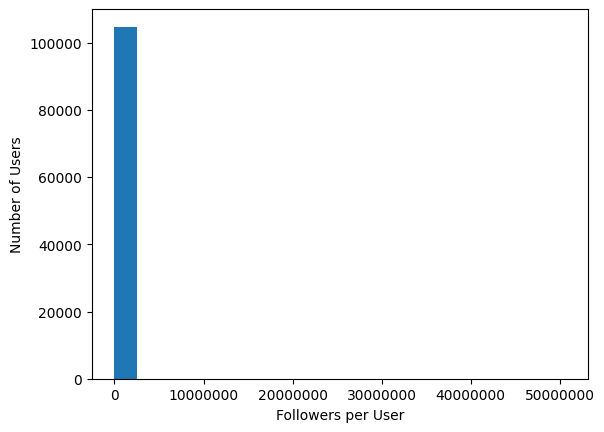

In [5]:
followers = [users[x]['followers_count'] for x in users.keys()]
print("Mean Follower Count:",statistics.mean(followers))
print("Median Follower Count:",statistics.median(followers))
print("Maximum Follower Count:",max(followers))
plt.ticklabel_format(style='plain')
plt.hist(followers,bins=20)
plt.xlabel("Followers per User")
plt.ylabel("Number of Users")
plt.show()

With the above histograms we can see verify that the means are true (6091 average followers per user & 1.67 average tweets per user). Isolating the maximums we can see that the distributions are highly skewed left, and that they may follow an exponential or poisson with a very low lambda (rate). The distributions aren't important, but the shape of the data is.

# Filter Data to Influencers

Because we are interested in visualizing the influencer population, we will reduce our study to users who have over 2x the mean followers (fairly influential) and 5x the mean tweets (they tweet a lot about fitness apparel). We are using a higher tweet count because we want to see who is routinely influencing the sporting goods space over the studied 90 day period.

In [6]:
included_user_ids = []

min_tweet_count = 5 # ~5x the mean
min_followers_count = 14000 # ~2x mean

for user_id, user in users.items():
    if user["tweet_count"] >= min_tweet_count and \
             user["followers_count"] >= min_followers_count:
        included_user_ids.append(user_id)

print("Length of Users List:", len(included_user_ids))

Length of Users List: 204


# Weighted Directed Graph of Influencers (all Brands)

Now that we have isolated roughly 200 influential user accounts, we have a group that we can visualize. Let's go ahead and build a directed graph to see what that looks like. (See Valued_Mentions.html)

In [7]:
graph = nx.MultiDiGraph()

with gzip.open(DATA_FILE) as data_file:
    for i, line in enumerate(data_file):
        if i % 10000 == 0:
            print("%s tweets processed" % i)
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        if sender_id in included_user_ids:
            sender_name = tweet["user"]["screen_name"]
            if sender_id in included_user_ids:
                for mention in tweet["entities"]["user_mentions"]:
                    receiver_name = mention["screen_name"]
                    receiver_id = mention["id"]
                    if receiver_id in included_user_ids:
                        graph.add_edge(sender_name, receiver_name)
print(graph)

0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
MultiDiGraph with 132 nodes and 8673 edges


In [8]:
# compute betweenness
bets = []
b = nx.betweenness_centrality(graph)
for v in graph.nodes():
    bets.append((b[v], v))

bets = sorted(bets, reverse=True)
print("Betweenness")
bets[0:25]


Betweenness


[(0.0009395184967704052, 'snkr_twitr'),
 (0.00041103934233705224, 'DeezeFi'),
 (0.00035231943628890195, 'tropoFarmer'),
 (0.00035231943628890195, 'boardroom'),
 (0.00035231943628890195, 'SneakerDropCo'),
 (0.00035231943628890195, 'MrUnloved1s'),
 (0.00035231943628890195, 'FinishLine'),
 (0.00035231943628890195, 'BlazePizza'),
 (0.0002348796241926013, 'economist'),
 (0.0002348796241926013, 'NickDePaula'),
 (0.00011743981209630065, 'shopWSS'),
 (0.00011743981209630065, 'iAmTMCII'),
 (0.00011743981209630065, 'FootwearNews'),
 (5.871990604815032e-05, 'wwd'),
 (5.871990604815032e-05, 'aarongreenberg'),
 (5.871990604815032e-05, 'UniWatch'),
 (5.871990604815032e-05, 'TheSmarmyBum'),
 (5.871990604815032e-05, 'PawlowskiMario'),
 (5.871990604815032e-05, 'JarlanPerez'),
 (5.871990604815032e-05, 'EvanKirstel'),
 (0.0, 'wilfriedboh'),
 (0.0, 'whoop'),
 (0.0, 'whatley_brady'),
 (0.0, 'unlvfootball'),
 (0.0, 'unclelukereal1')]

# Bridgers

Bridgers or users with high betweenness are listed above in descending order. It's interesting to notice that there aren't even 25 bridgers in this whole dataset.

In [30]:
degs = []
d = nx.degree_centrality(graph)
for v in graph.nodes():
    degs.append((d[v],v))
degs = sorted(degs,reverse=True)
print("Degree centrality")
degs[0:50]

Degree centrality


[(79.38931297709924, 'SneakerScouts'),
 (28.00763358778626, 'FinishLine'),
 (13.618320610687022, 'snipes_usa'),
 (1.4961832061068703, 'AilsaForshaw'),
 (1.0687022900763359, 'DavePOfficial'),
 (0.8854961832061068, 'RunBlogRun'),
 (0.7786259541984732, 'DaAnsahonSports'),
 (0.7099236641221374, 'solefed'),
 (0.47328244274809156, 'Xbox'),
 (0.3282442748091603, 'iAmTMCII'),
 (0.282442748091603, 'nikestore'),
 (0.2595419847328244, 'snkr_twitr'),
 (0.19083969465648853, 'LEGIQN'),
 (0.183206106870229, 'larryblustein'),
 (0.17557251908396945, 'UniWatch'),
 (0.16793893129770993, 'WiedenKennedy'),
 (0.16030534351145037, 'MrUnloved1s'),
 (0.16030534351145037, 'BlazePizza'),
 (0.1450381679389313, 'hotpockets'),
 (0.13740458015267176, 'whatley_brady'),
 (0.13740458015267176, 'unlvfootball'),
 (0.13740458015267176, 'PhilHecken'),
 (0.13740458015267176, 'Atari_Jones'),
 (0.1297709923664122, 'LAFC'),
 (0.12213740458015267, 'shopWSS'),
 (0.09923664122137404, 'realUNOgame'),
 (0.09923664122137404, 'Sneake

# Central Users

Degree centrality computes a value akin to importance in graph analysis. The above 25 accounts are the most central users in the dataset. You'll see these names again in the graphs. SneakerScouts and FinishLine are the most central users in the Nike Graph. Xbox and Legiqn are the most central users in the Adidas influencer graph below. DeezeFI and JohnKnopfPhotos are the most central in the Lululemon influencer graph.  

You'll also see AlisaForshaw, UNLV, LAFC, LaGalaxy, and solefed throughout this analaysis.

In [10]:
clos = []
c = nx.closeness_centrality(graph)
for v in graph.nodes():
    clos.append((c[v],v))
clos=sorted(clos,reverse=True)
print("Closeness centrality")
clos[0:25]

Closeness centrality


[(0.09841875681570338, 'Xbox'),
 (0.061832061068702295, 'nikestore'),
 (0.05343511450381679, 'snkr_twitr'),
 (0.041560644614079725, 'solefed'),
 (0.03740458015267175, 'FinishLine'),
 (0.03256997455470738, 'thesnkrsleaker'),
 (0.031806615776081425, 'realUNOgame'),
 (0.030534351145038167, 'tropoFarmer'),
 (0.028772753963593658, 'iPhonedo'),
 (0.02748091603053435, 'DeezeFi'),
 (0.024427480916030534, 'unlvfootball'),
 (0.023377862595419848, 'jdsportsus'),
 (0.022900763358778626, 'shopWSS'),
 (0.022900763358778626, 'clegfx'),
 (0.022900763358778626, 'Gfunkera86'),
 (0.02120441051738762, 'TheSocialStatus'),
 (0.0183206106870229, 'JohnKnopfPhotos'),
 (0.017448200654307522, 'BlazePizza'),
 (0.01717557251908397, 'LAGalaxy'),
 (0.01717557251908397, 'LAFC'),
 (0.01717557251908397, 'Jruffhouse'),
 (0.015267175572519083, 'wwd'),
 (0.015267175572519083, 'snipes_usa'),
 (0.015267175572519083, 'beijingdou'),
 (0.015267175572519083, 'aarongreenberg')]

I computed closeness of the users in the dataset even though it was not required. I'm not surprised to see these names either. They will feature prominently when we get to the influencer graphs by brand.

In [39]:
#!rm Valued_Mentions.html
nt = Network(notebook=True, directed=True, cdn_resources='remote',height="768px", width="1024px", bgcolor="#222222", font_color="white", select_menu=True)
# populates the nodes and edges data structures

nt.show_buttons(filter_=['nodes','physics'])
nt.from_nx(graph,default_node_size=40,default_edge_weight=2)

nt.save_graph('Valued_Mentions.html')
display(HTML('Valued_Mentions.html'))

(Please see Valued_Mentions.html available here: https://github.com/tbonesteaks/MarketingGraphAnalysis/)

You'll find a 132 node visualization with 8,673 edges. These are the twitter accounts who are influential in the space. However, the accounts in the 5 superstructures are more influential because they generate more tweets that get reactions from other influencers. Let's now see if those superstructures are the same for each of the brands.

Notable superstructures (in no particular order) include:
1. Los Angeles Football clubs (LAFC, LaGalaxy, and associated).
2. Sneaker shoe retailers (The Finish Line, Sneaker Scouts and Snipes have the highest Degree Centrality).
3. UNLV Athletics (University of Nevada Las Vegas).
4. XBox (gamers show the highest Closeness Centrality).

Also interesting, the accounts with the highest betweenness are the bridging accounts.

# Filter Influencers By Brand

The next three cells will filter influencers by brand, and build the networkx graphs structures.

In [12]:
graphnikeusers = nx.MultiDiGraph()

with gzip.open(DATA_FILE) as data_file:
    for i, line in enumerate(data_file):
        if i % 10000 == 0:
            print("%s tweets processed" % i)
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        text = tweet["full_text"].lower()
        if "@nike" in text and sender_id in included_user_ids:
            sender_name = tweet["user"]["screen_name"]
            for mention in tweet["entities"]["user_mentions"]:
                receiver_name = mention["screen_name"]
                receiver_id = mention["id"]
                if receiver_id in included_user_ids:
                    graphnikeusers.add_edge(sender_name, receiver_name)
print(graphnikeusers)

0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
MultiDiGraph with 87 nodes and 8005 edges


In [13]:
graphadidasusers = nx.MultiDiGraph()

with gzip.open(DATA_FILE) as data_file:
    for i, line in enumerate(data_file):
        if i % 10000 == 0:
            print("%s tweets processed" % i)
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        text = tweet["full_text"].lower()
        if "@adidas" in text and sender_id in included_user_ids:
            sender_name = tweet["user"]["screen_name"]

            for mention in tweet["entities"]["user_mentions"]:
                receiver_name = mention["screen_name"]
                receiver_id = mention["id"]
                if receiver_id in included_user_ids:
                    graphadidasusers.add_edge(sender_name, receiver_name)
print(graphadidasusers)

0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
MultiDiGraph with 55 nodes and 176 edges


In [14]:
graphlululemonusers = nx.MultiDiGraph()

with gzip.open(DATA_FILE) as data_file:
    for i, line in enumerate(data_file):
        if i % 10000 == 0:
            print("%s tweets processed" % i)
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        text = tweet["full_text"].lower()
        if "@lululemon" in text and sender_id in included_user_ids:
            sender_name = tweet["user"]["screen_name"]
            for mention in tweet["entities"]["user_mentions"]:
                receiver_name = mention["screen_name"]
                receiver_id = mention["id"]
                if receiver_id in included_user_ids:
                    graphlululemonusers.add_edge(sender_name, receiver_name)
print(graphlululemonusers)

0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
MultiDiGraph with 5 nodes and 10 edges


Filtering by brand nets far fewer nodes and edges per graph. We want to see if any of the superstructures remain by brand.

# Directed Influencer Graphs by Brand

The associated files have the exports of the following 3 cells:
1. NikeInfluencers.html
2. AdidasInfluencers.html
3. LululemonInfluencers.html

(These graph outputs are available here: https://github.com/tbonesteaks/MarketingGraphAnalysis/)


In [40]:

nt = Network(notebook=True, directed=True, cdn_resources='remote',height="768px", width="1024px", bgcolor="#674ef2", font_color="white", select_menu=True)
# populates the nodes and edges data structures
nt.show_buttons(filter_=['nodes','physics'])
nt.from_nx(graphnikeusers,default_node_size=40,default_edge_weight=2)

nt.save_graph('NikeInfluencers.html')
display(HTML('NikeInfluencers.html'))

In [41]:

nt = Network(notebook=True, directed=True, cdn_resources='remote',height="768px", width="1024px", bgcolor="#0c4df0", font_color="white", select_menu=True)
# populates the nodes and edges data structures
nt.show_buttons(filter_=['nodes','physics'])
nt.from_nx(graphadidasusers,default_node_size=40,default_edge_weight=2)

nt.save_graph('AdidasInfluencers.html')
display(HTML('AdidasInfluencers.html'))

In [43]:

nt = Network(notebook=True, directed=True, cdn_resources='remote',height="768px", width="1024px", bgcolor="#5d0185", font_color="white", select_menu=True)
# populates the nodes and edges data structures
nt.show_buttons(filter_=['nodes','physics'])
nt.from_nx(graphlululemonusers,default_node_size=40,default_edge_weight=2)

nt.save_graph('LululemonInfluencers.html')
display(HTML('LululemonInfluencers.html'))

When analysing the three graphs we see the following:

1. Adidias: Has roughly 3 superstructures. LA football clubs are the most tied to the brand (the adidas football acccount). The other 2 are more organic (XBox and IAMTmcII).

2. Lululemon: Has only 5 nodes, but 4 of the nodes are connected. This shows that those who support the brand seek out others who also are fanatics.

3. Nike: Has a giant superstructure in the middle of the graph. The largest number of tweets in the study are shown by edges between The Finish Line retail outlet, DavePOfficial, and Sneaker Scouts. This group has some satellites including the SneakerDropCo, which is by far the largest bridger seen so far in the study. SneakerDropCo bridges the group surrounding the NikeStore (15 connected Nodes) to the FinishLine and SneakerScouts (6 connected Nodes). Other notable Nike structures include the following bridgers; UNLV Athletics Grouping (5 connected Nodes), Mattel with Footwear News (6 connected Nodes), XBOX (10 connected Nodes), clegfx (6 connected Nodes), TropoFarmer (5 connected Nodes).

# Semantic Segmentation of Influencers by Brand

Now that we know who is talking about the brand and how they are connected, let's see what they are saying. This is a multiple step process where we tokenize and characterize each word, tag the parts of speech (POS), and then filter based on the POS. The POS tagging step also includes steps to remove stop words, urls, etc..

* I looked at the verbs for this section first. The results were inconclusive at best. Instead, we'll keep the nouns, but they are too plentiful to graph effectively (i.e. over 1500 noun nodes for Adidas). So an extra step, counting the edges and taking the top 324 is what we'll do below.

In [18]:
# build a function to extract the tokens, clean them, count them, and return a dictionary.
def token_graph(tagger=nltk.tag.PerceptronTagger().tag,
                 tokenizer=nltk.TweetTokenizer().tokenize,
                 parts_of_speech=['VB','NN'], mention=None):

    #set variables
    graphtoks = nx.MultiDiGraph()

    #helper function to make tagged wordsalad
    def tokenize(words):
        #remove urls
        words = re.sub(r"http\S+", "", words)
        #tokenize
        wordsalad = tokenizer(words)
        #remove stop words
        goodwords = []
        for aword in wordsalad:
            if aword not in stopwordsset:
                goodwords.append(aword)
        wordsalad = goodwords.copy()
        del goodwords

        # #remove punctuation:
        # nopunctwords = []
        # for aword in wordsalad:
        #     if aword not in punctuation:
        #         nopunctwords.append(aword)
        # cleanedwords = []
        # for aword in nopunctwords:
        #     aword = aword.translate(str.maketrans('', '', string.punctuation))
        #     cleanedwords.append(aword)
        # wordsalad = cleanedwords.copy()
        # del cleanedwords, nopunctwords

        #tag tokens
        wordsalad = tagger(wordsalad)
        return wordsalad

    #run through data file and make graph
    with gzip.open(DATA_FILE) as data_file:
        for i, line in enumerate(data_file):
            if i % 10000 == 0:
                print("%s tweets processed" % i)
            tweet = json.loads(line)
            sender_id = tweet["user"]["id"]
            text = tweet["full_text"].lower()
            if mention in text and sender_id in included_user_ids:
                toks = tokenize(text)
                x = len(toks)

                for j in range(x):
                    for k in range(j+1,x):
                        if toks[j][1] in parts_of_speech and toks[k][1] in parts_of_speech:
                            graphtoks.add_edge(toks[j][0], toks[k][0])

    return graphtoks


In [19]:
niketokens = token_graph(mention="@nike")
print("Nike:",niketokens)
adidastokens = token_graph(mention="@adidas")
print("Adidas:",adidastokens)
lululemontokens = token_graph(mention="@lululemon")
print("Lululemon:",lululemontokens)

0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
Nike: MultiDiGraph with 2631 nodes and 132285 edges
0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
Adidas: MultiDiGraph with 1374 nodes and 9558 edges
0 tweets processed
10000 tweets processed
20000 tweets proce

In [20]:
def graphsubs(tokenlist):
    #set variables
    graphsubtoks = nx.MultiDiGraph()
    for i in tokenlist:
        for j in range(i[0]):
            graphsubtoks.add_edge(i[1][0], i[1][1])

    return graphsubtoks

In [21]:
topnike = {}
for edg in niketokens.out_edges():
    if edg in topnike.keys():
        topnike[edg] +=1
    else:
        topnike[edg] = 1
#we will take an order of magnitude out of these by dividing by 10
topn = sorted([(round(v/10),k) for k,v in topnike.items()],reverse=True)
topni = pd.DataFrame(topn[0:150])
topni.columns = ['Count','Keywords']
niketokens2 = graphsubs(topn[0:150])
print("Nike:",niketokens2)
print("** REMEMBER, THESE COUNTS ARE 1/10th OF OBSERVATIONS...")

Nike: MultiDiGraph with 46 nodes and 6124 edges
** REMEMBER, THESE COUNTS ARE 1/10th OF OBSERVATIONS...


In [32]:
print("Word Clusters Nike Owns: (multiply counts by 10)")
topni.iloc[0:30,:]

Word Clusters Nike Owns: (multiply counts by 10)


,Count,Keywords
0,474,"(air, @nike)"
1,389,"(#ad, air)"
2,354,"(#ad, @nike)"
3,304,"(@finishline, @nike)"
4,268,"(air, @finishline)"
5,218,"(#ad, @finishline)"
6,154,"(@snipes_usa, @nike)"
7,124,"(air, @snipes_usa)"
8,123,"(women's, @nike)"
9,111,"(#ad, @snipes_usa)"


In [34]:
# compute betweenness or bridging words for Nike
betn = []
b = nx.betweenness_centrality(niketokens2)
for v in niketokens2.nodes():
    betn.append((b[v], v))

betn = sorted(betn, reverse=True)
print("Nike Bridging Words computed by Betweenness")
betn[0:25]


Nike Bridging Words computed by Betweenness


[(0.013299663299663301, 'air'),
 (0.011363636363636364, '@finishline'),
 (0.00202020202020202, '/'),
 (0.0014309764309764308, 'flyknit'),
 (0.0012626262626262625, '@snipes_usa'),
 (0.0007575757575757576, 'blazer'),
 (0.000505050505050505, 'force'),
 (0.0002525252525252525, 'university'),
 (0.0002525252525252525, 'grey'),
 (0.00016835016835016833, 'vapormax'),
 (0.0, '…'),
 (0.0, "women's"),
 (0.0, 'wolf'),
 (0.0, 'uptempo'),
 (0.0, 'unity'),
 (0.0, 'thunder'),
 (0.0, 'summit'),
 (0.0, 'suede'),
 (0.0, 'space'),
 (0.0, 'se'),
 (0.0, 'royal'),
 (0.0, 'release'),
 (0.0, 'pixel'),
 (0.0, 'pink'),
 (0.0, 'pack')]

This shows that there are only 9 bridging words in the top 150 combinations for Nike. * Remember that this is only the top 150 permutations.

In [23]:
topadidas = {}
for edg in adidastokens.out_edges():
    if edg in topadidas.keys():
        topadidas[edg] +=1
    else:
        topadidas[edg] = 1
topa = sorted([(v,k) for k,v in topadidas.items()],reverse=True)
topad = pd.DataFrame(topa[0:150])
topad.columns = ['Count','Keywords']
adidastokens2 = graphsubs(topa[0:150])
print("Adidas:",adidastokens2)


Adidas: MultiDiGraph with 113 nodes and 827 edges


In [33]:
print("Word Clusters Adidas Owns:")
topad.iloc[0:30,:]

Word Clusters Adidas Owns:


,Count,Keywords
0,13,"(world, know)"
1,13,"(go, world)"
2,13,"(go, know)"
3,12,"(iphone, catalyst)"
4,12,"(iphone, #phonecase)"
5,12,"(catalyst, #phonecase)"
6,12,"(@ailsaforshaw, world)"
7,12,"(@ailsaforshaw, know)"
8,12,"(@ailsaforshaw, go)"
9,11,"(time, compare)"


In [35]:
# compute betweenness or bridging words for Adidas
beta = []
b = nx.betweenness_centrality(adidastokens2)
for v in adidastokens2.nodes():
    beta.append((b[v], v))

beta = sorted(beta, reverse=True)
print("Adidas Bridging Words computed by Betweenness")
beta[0:25]

Adidas Bridging Words computed by Betweenness


[(0.002574002574002574, '@adidas'),
 (0.0014478764478764478, 'shop'),
 (0.0012065637065637065, '’'),
 (0.0008043758043758043, 'track'),
 (0.0005630630630630631, '%'),
 (0.00048262548262548264, 'yeezy'),
 (0.00024131274131274132, 'street'),
 (0.00024131274131274132, 'online'),
 (0.00024131274131274132, 'collection'),
 (0.00020109395109395108, 'visit'),
 (8.043758043758043e-05, 'tech'),
 (8.043758043758043e-05, 'los'),
 (8.043758043758043e-05, '@xbox'),
 (4.021879021879022e-05, 'purchase'),
 (0.0, '📲'),
 (0.0, '🍑'),
 (0.0, '️'),
 (0.0, '\u2060'),
 (0.0, '…'),
 (0.0, 'year'),
 (0.0, 'xbox'),
 (0.0, 'wotherspoon'),
 (0.0, 'world'),
 (0.0, "week's"),
 (0.0, "we've")]

This shows that there are only 12 bridging words in the top 150 combinations for Adidas. * Remember that this is only the top 150 permutations.

In [25]:
toplululemon = {}
for edg in lululemontokens.out_edges():
    if edg in toplululemon.keys():
        toplululemon[edg] +=1
    else:
        toplululemon[edg] = 1
topl = sorted([(v,k) for k,v in toplululemon.items()],reverse=True)
toplu = pd.DataFrame(topl[0:150])
toplu.columns = ['Count','Keywords']
lululemontokens2 = graphsubs(topl[0:150])
print("Lululemon:",lululemontokens2)



Lululemon: MultiDiGraph with 89 nodes and 290 edges


In [31]:
print("Word Clusters Lululemon Owns:")
toplu.iloc[0:30,:]

Word Clusters Lululemon Owns:


,Count,Keywords
0,6,"(design, shape)"
1,4,"(week, 😂)"
2,3,"(wardrobe, winter)"
3,3,"(olympic, paralympic)"
4,3,"(go, someone)"
5,3,"(go, go)"
6,3,"(design, surface)"
7,3,"(design, mean)"
8,3,"(design, design)"
9,3,"(design, combination)"


In [36]:
# compute betweenness or bridging words for Lululemon
betl = []
b = nx.betweenness_centrality(lululemontokens2)
for v in lululemontokens2.nodes():
    betl.append((b[v], v))

betl = sorted(betl, reverse=True)
print("Lululemon Bridging Words computed by Betweenness")
betl[0:25]

Lululemon Bridging Words computed by Betweenness


[(0.0031347962382445144, 'design'),
 (0.0017633228840125393, '@lululemon'),
 (0.0010449320794148381, 'change'),
 (0.0007836990595611286, 'budget'),
 (0.0006530825496342738, 'shape'),
 (0.0005224660397074191, 'sweat'),
 (0.0003918495297805643, 'winter'),
 (0.0003918495297805643, 'home'),
 (0.0003265412748171369, 'mask'),
 (0.00013061650992685477, 'please'),
 (0.00013061650992685477, 'go'),
 (0.0, '😎'),
 (0.0, '😂'),
 (0.0, '🍁'),
 (0.0, '…'),
 (0.0, '’'),
 (0.0, 'zero'),
 (0.0, 'yo'),
 (0.0, 'yesterday'),
 (0.0, 'year'),
 (0.0, 'yeah'),
 (0.0, 'worth'),
 (0.0, 'week'),
 (0.0, 'wear'),
 (0.0, 'wardrobe')]

This shows that there are only 11 bridging words in the top 150 combinations for Lululemon. * Remember that this is only the top 150 permutations.

Based on these lists, we can already see that NIKE conversations revolve around the brand. The words associated (air, nike, flyknit, force, and vapor) are all trademarks of the brand. That Footlocker and FinishLine are represented, two major Nike retailers, is also a sign of prowess for the Brand. Althought there are only 9 bridging words, they are all important to Nike.

Adidas, on the other hand, doesn't have the same marketing prowess. The word list is dominated by words not nearly associated with the brand. @adidas doesn't show up until #21 in the list. @alisaforshaw may be an influencer they would like to have add more @mentions as she dominates the top 20. Of the 12 bridging words associated with Adidas, only a few are associated with the brand. XBOX is a glaring example of how Adidas is not in control of their messaging. This means that Adidas has much more work to do regarding the brand.

Finally, when we look at the Lululemon word lists, we see some encouraging signs. Although the wordlist isn't purely dominated by related words, there are some relevant entrants. Words like athleisure, shape, design, and fit are marketing ideas that the brand would like to become synonymous. That we see 11 bridging words associated with Lululemon that could easily be associated with the brand is also encouraging. I do think that Lululemon needs more influencers to claim their space, but those identified are contributing to the brand effectively.

# Semantic Graphs

To confirm these analytical theories, let's take a look at how the semantic graphs for each brand look.

(These graph outputs are available here: https://github.com/tbonesteaks/MarketingGraphAnalysis/)

In [44]:

nt = Network(notebook=True, directed=True, cdn_resources='remote',height="768px", width="1024px", bgcolor="#674ef2", font_color="white", select_menu=True)
# populates the nodes and edges data structures
nt.show_buttons(filter_=['physics','nodes'])
nt.from_nx(niketokens2,default_node_size=40,default_edge_weight=2)
nt.save_graph('NikeWords.html')
display(HTML('NikeWords.html'))



In [45]:
nt = Network(notebook=True, directed=True, cdn_resources='remote',height="768px", width="1024px", bgcolor="#0c4df0", font_color="white", select_menu=True)
# populates the nodes and edges data structures
nt.show_buttons(filter_=['physics','nodes'])
nt.from_nx(adidastokens2,default_node_size=40,default_edge_weight=2)
nt.save_graph('AdidasWords.html')
display(HTML('AdidasWords.html'))


In [46]:
nt = Network(notebook=True, directed=True, cdn_resources='remote',height="768px", width="1024px", bgcolor="#5d0185", font_color="white", select_menu=True)
# populates the nodes and edges data structures
nt.show_buttons(filter_=['physics','nodes'])
nt.from_nx(lululemontokens2,default_node_size=40,default_edge_weight=2)
nt.save_graph('LululemonWords.html')
display(HTML('LululemonWords.html'))

As expected, the Adidas graph looks highly segmented. The Nike Graph looks very interconnected. And the Lululemon Graph looks like a mix of the two.

# Sentiment Analysis

Before we go, let's take a look at the sentiment of these tweets. The mean of the tweet sentiments are important in gauging the urgency of this analysis. If all the consumers are angry, the brand would like to know. We'll use textblob to score all the tweets of the 4 categories (All Influencers, Influencer Nike mentions, Influencer Adidas mentions, and Influencer Lululemon mentions) and then build some violin plots so we can visualize how people feel.

In [28]:
# lists for each sentiment scoring category
ts, ns, ads, ls = [],[],[],[]

# populate the 4 lists

# total sentiment
with gzip.open(DATA_FILE) as data_file:
    for i, line in enumerate(data_file):
        if i % 10000 == 0:
            print("%s tweets processed" % i)
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        text = tweet["full_text"].lower()
        if sender_id in included_user_ids:
            scorer = TextBlob(text)
            ts.append(scorer.sentiment[0])

 # nike sentiment
with gzip.open(DATA_FILE) as data_file:
    for i, line in enumerate(data_file):
        if i % 10000 == 0:
            print("%s tweets processed" % i)
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        text = tweet["full_text"].lower()
        if "@nike" in text and sender_id in included_user_ids:
            scorer = TextBlob(text)
            ns.append(scorer.sentiment[0])

 # adidas sentiment
with gzip.open(DATA_FILE) as data_file:
    for i, line in enumerate(data_file):
        if i % 10000 == 0:
            print("%s tweets processed" % i)
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        text = tweet["full_text"].lower()
        if "@adidas" in text and sender_id in included_user_ids:
            scorer = TextBlob(text)
            ads.append(scorer.sentiment[0])

 # lululemon sentiment
with gzip.open(DATA_FILE) as data_file:
    for i, line in enumerate(data_file):
        if i % 10000 == 0:
            print("%s tweets processed" % i)
        tweet = json.loads(line)
        sender_id = tweet["user"]["id"]
        text = tweet["full_text"].lower()
        if "@lululemon" in text and sender_id in included_user_ids:
            scorer = TextBlob(text)
            ls.append(scorer.sentiment[0])

0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 t

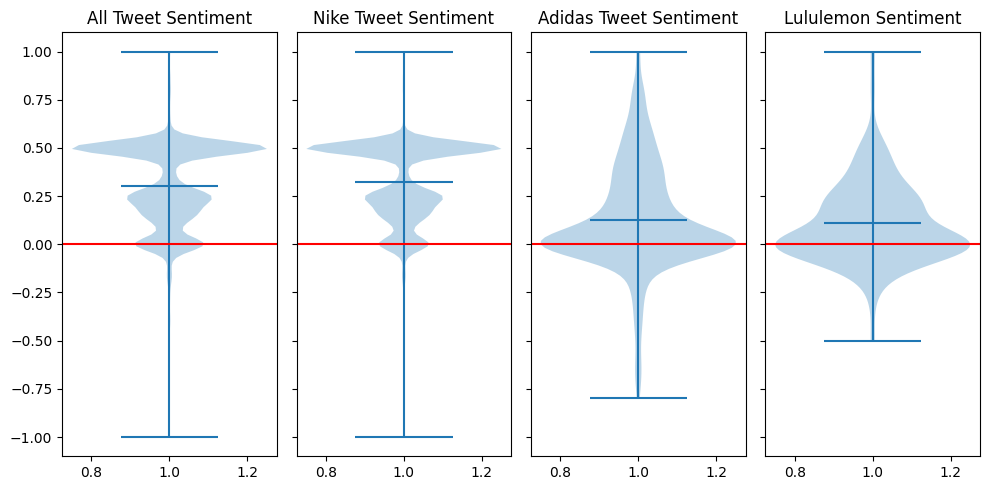

In [29]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 5), sharey='row')
#axes_cols = (axes.flatten()[::2], axes.flatten()[1::2])

ax1.violinplot(ts,showmeans=True,showextrema=True)
ax1.axhline(y=0,c='r')
ax2.violinplot(ns,showmeans=True,showextrema=True)
ax2.axhline(y=0,c='r')
ax3.violinplot(ads,showmeans=True,showextrema=True)
ax3.axhline(y=0,c='r')
ax4.violinplot(ls,showmeans=True,showextrema=True)
ax4.axhline(y=0,c='r')
ax1.set_title('All Tweet Sentiment')
ax2.set_title('Nike Tweet Sentiment')
ax3.set_title('Adidas Tweet Sentiment')
ax4.set_title('Lululemon Sentiment')

fig.tight_layout()

These sentiment results are encouraging. The sentiment of the whole dataset is positive. Nike, being the largest contingent in the dataset, has a distribution that mimics the dataset with a slightly higher mean sentiment score. Adidas and Lululemon do have some negative sentiment from influencers. However, their averages are both above the zero line (red), indicating more happy influencer comments than not. But this shows that there is significant room for improvment.

# Conclusion:

In this notebook we have defined what people mean when they say that Nike is one of the best marketing companies in the world. Not only are the tweets that mention the brand on message, they are numerous, include the retailers that distribute their products, and are mostly positive from a sentiment analysis point of view. This is truly an accomplishment. The fact that these metrics are sustained over a multiple decades are nothing less than impressive.

Adidas, on the other hand, doesn't control the message regarding their brand online. Influencer mentions are not coordinated, do not convey the brand trademarks, and are often part of other passing discussions. That the gaming community is more prevalent than any Adidas effort shows the magnitude of the work to be done.

Finally, Lululemon, a fairly new brand in age, is starting to really define the brand in the public forum. The popular keywords associated are mostly relevant, the result of the firm efforts, and point to their fairly effective marketing campaigns. Although there is some room for improvement in volume of tweets, sentiment, and message targeting, this analysis shows that Lululemon is much farther along in coordinating their marketing efforts than is Adidas. Yet they trail the marketing prowess of Nike by an equally large margin.